## Before you start

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Fri Mar  7 04:08:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   52C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install dependencjes

**Note:** Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs. `inference-gpu` utilizes the `onnxruntime-gpu` library internally for optimal performance. We'll install a specific version of `onnxruntime-gpu` to guarantee compatibility with the CUDA 12 environment in Google Colab.

In [ ]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

**Note:** Let's install the sports repository directly from GitHub. The sports repository contains a variety of football-related utilities that we'll use along the way.

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


**Note:** Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [ ]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1


**Note:** Let's download a few sample videos from the [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout) Kaggle competition using gdown.



In [ ]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 82.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 37.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 26.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 34.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 33.9MB/s]


In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, player, goalkeeper and referee detection

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "basketball-players-fy4c2/16"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration d

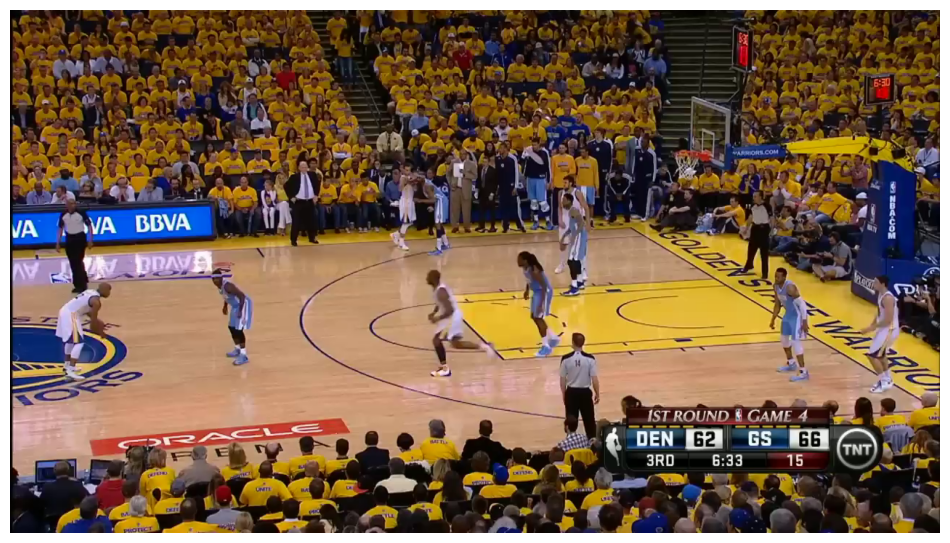

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

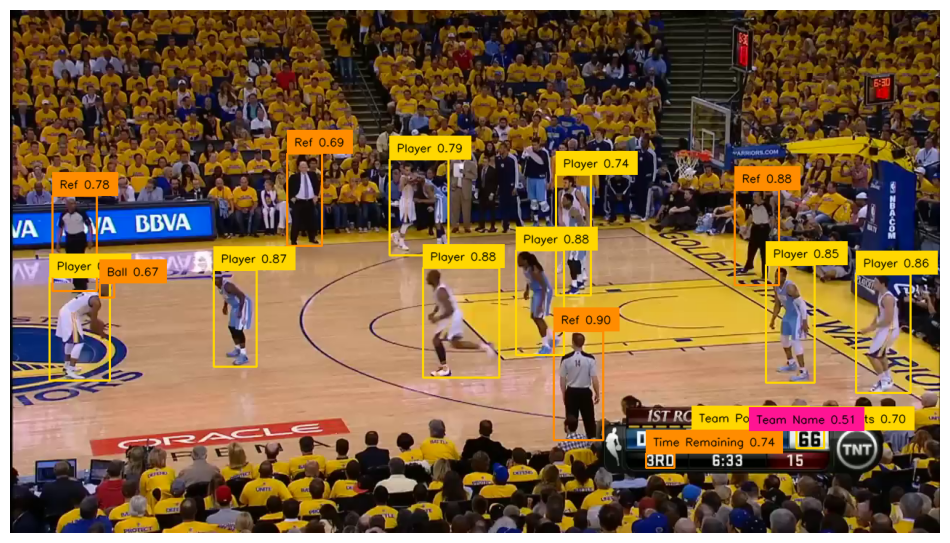

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0] # j'ai du augmenter la confidence car certains objets étaient mal détectés commme des joueurs
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

## video game style visualization

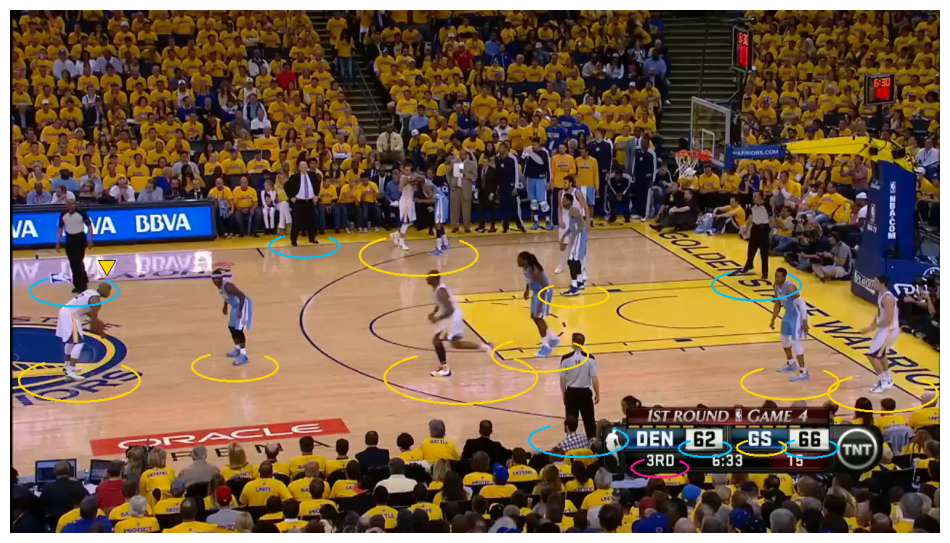

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## player tracking

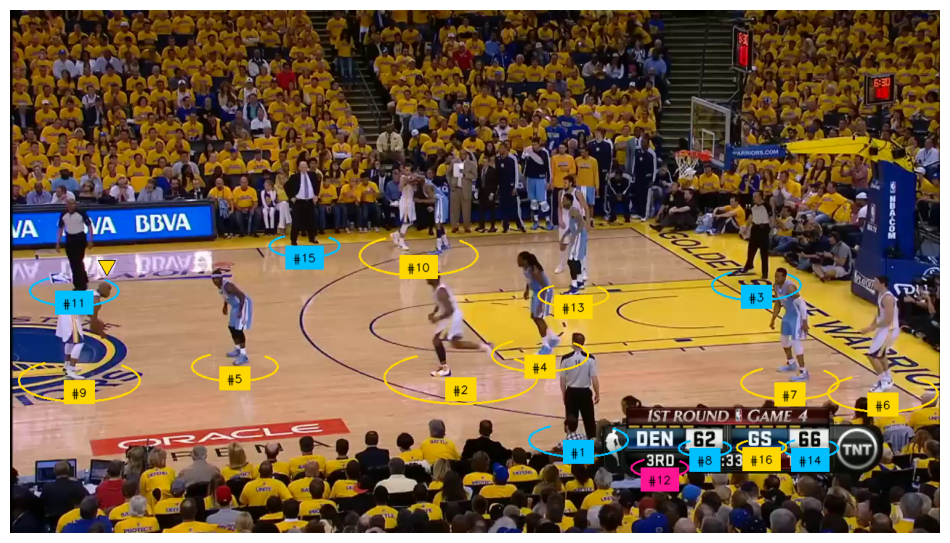

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## split players into teams

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-team-clustering.png)

**Note:** Before training our player clustering model, we need to gather training data. To do this, we'll sample one frame per second, detect players within those frames, and then crop them out.

collecting crops: 112it [00:11,  9.56it/s]


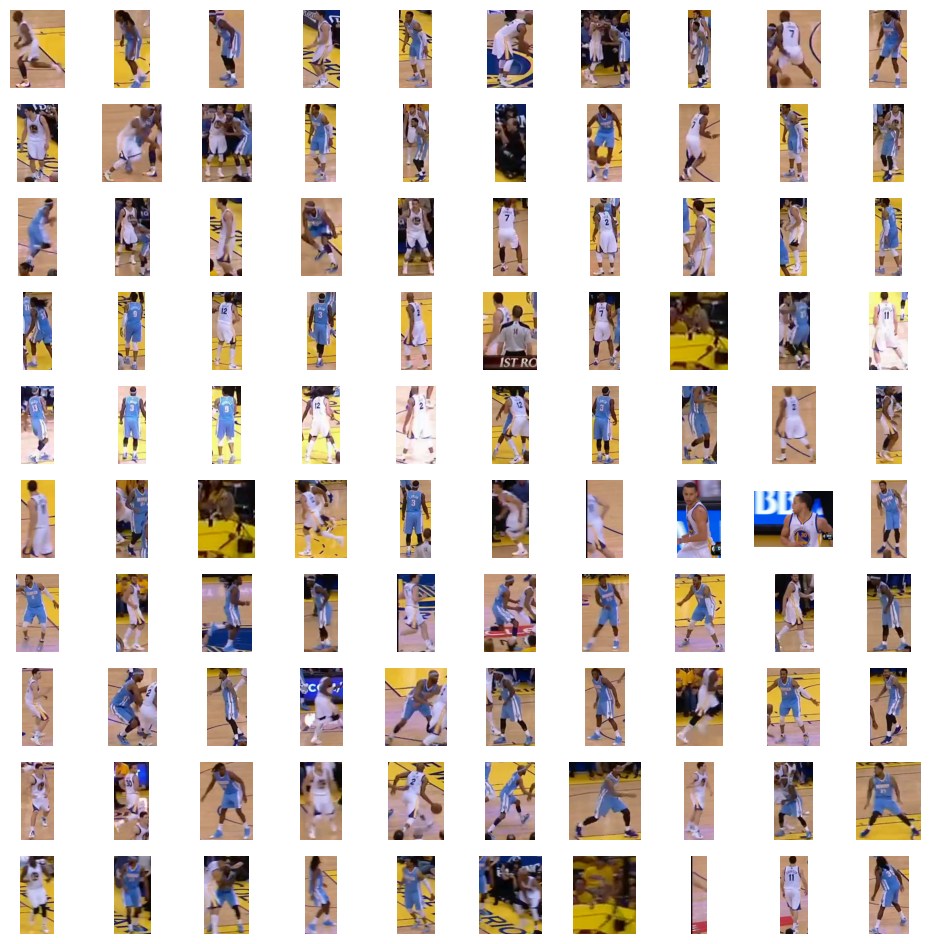

In [ ]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"
PLAYER_ID = 3
STRIDE = 35

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [ ]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [ ]:
import numpy as np
from more_itertools import chunked
import torch
BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 17it [00:04,  4.11it/s]


In [ ]:
import cv2
import numpy as np
import torch
from transformers import AutoProcessor, SiglipVisionModel
import umap
from tqdm import tqdm
from typing import List
from sklearn.cluster import KMeans

class TeamClassifier:
    def __init__(self, device: str = 'cpu', batch_size: int = 32):
        self.device = device
        self.batch_size = batch_size
        self.features_model = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(device)
        self.processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)
        self.reducer = umap.UMAP(n_components=3)
        self.cluster_model = KMeans(n_clusters=2)

    def extract_enhanced_features(self, crop: np.ndarray) -> np.ndarray:
        """
        Extrait des features améliorées pour un crop donné.
        Combine l'embedding SigLIP, la couleur dominante et la texture.
        """
        # Embedding SigLIP
        pillow_crop = sv.cv2_to_pillow(crop)
        inputs = self.processor(images=[pillow_crop], return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.features_model(**inputs)
            embedding = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy().flatten()

        # Couleur dominante (HSV)
        hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0], None, [180], [0, 180])
        dominant_hue = np.argmax(hist)

        # Texture (variance de Laplacian)
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        texture = cv2.Laplacian(gray, cv2.CV_64F).var()

        return np.concatenate([embedding, [dominant_hue, texture]])

    def extract_features(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Extrait les features pour une liste de crops.
        Utilise extract_enhanced_features en interne.
        """
        features = []
        for crop in crops:
            features.append(self.extract_enhanced_features(crop))
        return np.array(features)

    def fit(self, crops: List[np.ndarray]) -> None:
        """
        Entraîne le modèle sur une liste de crops.
        """
        data = self.extract_features(crops)
        projections = self.reducer.fit_transform(data)
        self.cluster_model.fit(projections)

    def predict(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Prédit les clusters pour une liste de crops.
        """
        if len(crops) == 0:
            return np.array([])
        data = self.extract_features(crops)
        projections = self.reducer.transform(data)
        return self.cluster_model.fit_predict(projections)

In [ ]:
import supervision as sv
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"
PLAYER_ID = 3
STRIDE = 35

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 112it [00:11,  9.68it/s]


Avant attribution: [3 3 3 3 3 3 3 3]
Après attribution: [1 1 1 0 0 0 0 0]


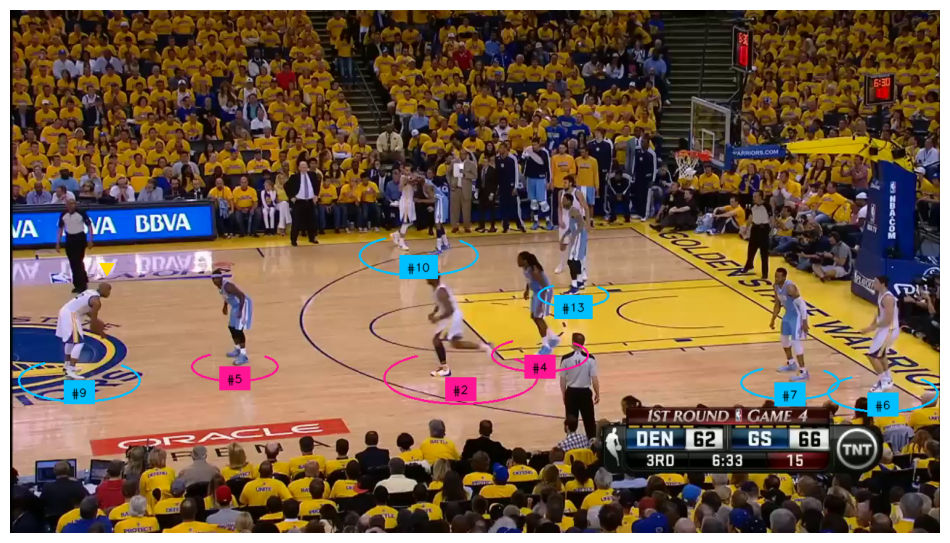

In [ ]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/content/PIE/Train_GSW.mp4"
BALL_ID = 0
PLAYER_ID = 3
REFEREE_ID = 4
TEAM_COLORS = ['#00BFFF', '#FF1493']  # Bleu ciel vs Rose

# Annotateurs avec palette adaptée
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(TEAM_COLORS + ['#FFD700']),  # + couleur ballon
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

# Debug des class IDs
print("Avant attribution:", players_detections.class_id)

# Attribution d'équipe améliorée
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
if len(players_crops) > 0:
    players_detections.class_id = team_classifier.predict(players_crops)
    print("Après attribution:", players_detections.class_id)

# Validation des IDs
players_detections.class_id = np.where(
    players_detections.class_id >= len(TEAM_COLORS),
    0,  # Fallback si ID hors limite
    players_detections.class_id
)

referees_detections.class_id = 0

all_detections = sv.Detections.merge([
    players_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections
])


In [8]:
!git clone https://github.com/CedricDada/PIE.git

Cloning into 'PIE'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 184 (delta 2), reused 1 (delta 1), pack-reused 168 (from 5)
Receiving objects: 100% (184/184), 101.20 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (78/78), done.
